# Introduction

The climate change is a serious global threat for the mankind and nature. The biggest factor for the accelerated global warming is the carbon dioxide ($CO_2$) emissions from human activities.

In this project we study the correlation between income levels and $CO_2$ emissions of different countries using Bayesian workflow. We use statistical data from year 2014 of income per capita and $CO_2$ emissions per capita of each country. We build two gaussian linear models, pooled and hierarchical, and compare them. In the hierarchical model the countries are grouped into six continents

We conclude that there's a linear relation between $log(income)$ and $log(CO_2)$. In other words richer countries generate more $CO_2$.

This notebook is an extension and adaptation to Python of the final project done together with Harri Pohja for the course [Bayesian Data Analysis](https://mycourses.aalto.fi/course/view.php?id=24401), from Aalto University.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

import pystan
import arviz as az

In [2]:
# edit default plot settings
plt.rc('font', size=12)
az.style.use('seaborn-darkgrid')
plt.rcParams['figure.figsize'] = [10, 6.3]

# Source Data


For obtaining the data we used the interface provided by Gapminder https://open-numbers.github.io/datasets.html


## 1. Income per person (GDP/capita, PPP in dollars inflation-adjusted)

Description: Gross domestic product per person adjusted for differences in purchasing power (in international dollars, fixed 2011 prices, PPP based on 2011 ICP).

Source name: Gapminder based on World Bank, A. Maddison, M. Lindgren, IMF & more.

More information: http://gapm.io/dgdppc

In [3]:
url = 'https://raw.githubusercontent.com/open-numbers/ddf--gapminder--gdp_per_capita_cppp/master/' \
    + 'ddf--datapoints--income_per_person_gdppercapita_ppp_inflation_adjusted--by--geo--time.csv'
income = pd.read_csv(url, error_bad_lines=False)
income.head()

,geo,time,income_per_person_gdppercapita_ppp_inflation_adjusted
0,afg,1800,603
1,afg,1801,603
2,afg,1802,603
3,afg,1803,603
4,afg,1804,603


## 2. CO2 emissions (tonnes per person)

Description: Carbon dioxide emissions from the burning of fossil fuels (metric tonnes of $CO_2$ per person).

More information: https://cdiac.ess-dive.lbl.gov

In [4]:
url = 'https://raw.githubusercontent.com/open-numbers/ddf--gapminder--systema_globalis/master/' \
    + 'countries-etc-datapoints/ddf--datapoints--co2_emissions_tonnes_per_person--by--geo--time.csv'
co2 = pd.read_csv(url, error_bad_lines=False)
co2.head()

,geo,time,co2_emissions_tonnes_per_person
0,afg,1949,0.00192
1,afg,1950,0.01088
2,afg,1951,0.01169
3,afg,1952,0.01155
4,afg,1953,0.01323


## 3. List of countries by continent

Description: This dataset consists of list of countries by continent. Continent codes and country codes are also included.

Source link: https://datahub.io/JohnSnowLabs/country-and-continent-codes-list

*Data requires to correct some import complications between the csv and pandas*

In [5]:
url = 'https://pkgstore.datahub.io/JohnSnowLabs/country-and-continent-codes-list/' \
    + 'country-and-continent-codes-list-csv_csv/data/' \
    + 'b7876b7f496677669644f3d1069d3121/country-and-continent-codes-list-csv_csv.csv'
ct_map = pd.read_csv(url, error_bad_lines=False)

# Correcting import to NA instead of NaN
ct_map.loc[ct_map['Continent_Name']=='North America', 'Continent_Code'] = 'NA'

# Adding column to map to toher tables
ct_map['geo'] = ct_map.Three_Letter_Country_Code.str.lower()

ct_map.head()

,Continent_Name,Continent_Code,Country_Name,Two_Letter_Country_Code,Three_Letter_Country_Code,Country_Number,geo
0,Asia,AS,"Afghanistan, Islamic Republic of",AF,AFG,4.0,afg
1,Europe,EU,"Albania, Republic of",AL,ALB,8.0,alb
2,Antarctica,AN,Antarctica (the territory South of 60 deg S),AQ,ATA,10.0,ata
3,Africa,AF,"Algeria, People's Democratic Republic of",DZ,DZA,12.0,dza
4,Oceania,OC,American Samoa,AS,ASM,16.0,asm


## Source data preparation

In [6]:
# Joining different sources of information
df = ct_map.join(income.set_index('geo'), on='geo', how='inner')
df = df.merge(co2, on=['geo','time'], how='inner')


# Categorical encoding for continents
df['Continent_Code'] = df['Continent_Code'].astype('category')
df['continent_number'] = df['Continent_Code'].cat.codes+1

# Renaming columns
df = df.rename(columns={"Continent_Name":"continent",
                        "income_per_person_gdppercapita_ppp_inflation_adjusted":"income",
                        "co2_emissions_tonnes_per_person":"co2",
                        "time":"year"})

# Selecting subset
df = df[['continent', 'continent_number','geo','year','income','co2']]
df.head()

,continent,continent_number,geo,year,income,co2
0,Asia,2,afg,1949,2357,0.00192
1,Asia,2,afg,1950,2392,0.01088
2,Asia,2,afg,1951,2422,0.01169
3,Asia,2,afg,1952,2462,0.01155
4,Asia,2,afg,1953,2568,0.01323


Selecting only data for 2013 onwards and add log transformations

In [7]:
# Filter year
df = df[df['year']>=2013]

# Logarithmic transformation of co2 & income
df['log_income'] = np.log(df['income'])
df['log_co2'] = np.log(df['co2'])

df.head()

,continent,continent_number,geo,year,income,co2,log_income,log_co2
64,Asia,2,afg,2013,1808,0.28027,7.499977,-1.272002
65,Asia,2,afg,2014,1796,0.25342,7.493317,-1.372707
66,Asia,2,afg,2015,1767,0.26231,7.477038,-1.338228
67,Asia,2,afg,2016,1757,0.24476,7.471363,-1.407477
68,Asia,2,afg,2017,1758,0.24737,7.471932,-1.396870


In [8]:
# Checking null values
df.isnull().values.any()

False

## Problem analysis
First we will evaluate possible correlations in the data trough visualisations

### Visualisations

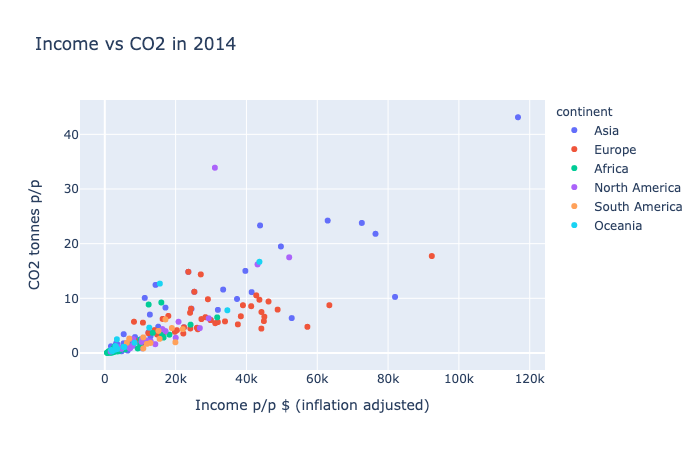

In [9]:
# Subset of df for visualisations
year = 2014
df_plt = df[df['year']==year]

fig = px.scatter(df_plt, x='income',y='co2', color='continent',
           labels={
                     "income": "Income p/p $ (inflation adjusted)",
                     "co2": "CO2 tonnes p/p",
                     "continent_name": "Continent"
                 },
           title=f"Income vs CO2 in {year}")

# Show static image instead of interactive for github
fig.show("png")

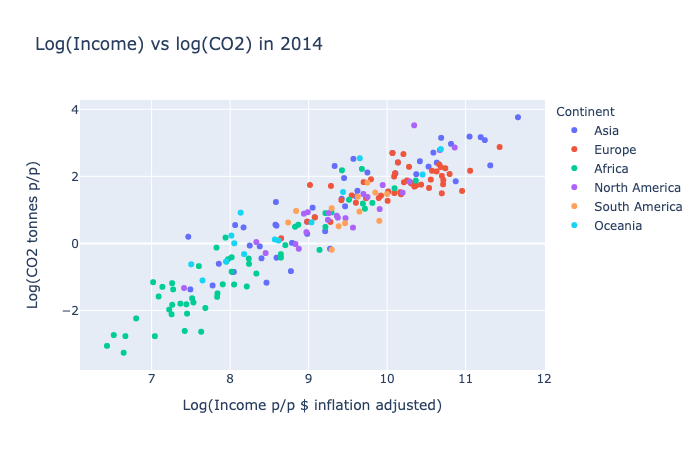

In [10]:
# Visualise again with logs
fig = px.scatter(df_plt, x='log_income',y='log_co2', color='continent',
           labels={
                     "log_income": "Log(Income p/p $ inflation adjusted)",
                     "log_co2": "Log(CO2 tonnes p/p)",
                     "continent": "Continent"
                 },
           title=f"Log(Income) vs log(CO2) in {year}")

# Show static image instead of interactive for github
fig.show("png")

### Choosing the models based on the visualisations

We can observe that there's a linear relation between log(Income) and log($CO_2$) across all continents. Thus we can model it as:
$log(CO_2)=\alpha + \beta * log(Income)$.

In other words, the $CO_2$ emissions per person of each country is proportional to the income per person of that country – the higher the standard of living in a country is, the more $CO_2$ emissions the country generates. It also implies that when the country's standard of living improves, also $CO_2$ emissions increase.

We can also identify that different continents have slightly different trends.


# Model description

We are going to generate two models to predict $CO_2$ emissions: a pooled model and a hierarchical model.

## Pooled model
  
All the countries have the same distribution for $\alpha, \beta$ and $\sigma$ parameters.
  
$log({CO_2}_i) \sim N(\alpha + \beta * log(Income_i), \sigma)$
  
## Hierarchical model
  
  There are a hyper parameters for the distribution of  $\alpha_0$ and $\beta_0$ connecting continent specific parameters $\alpha$ and $\beta$, while $\sigma$ is common for all the countries. In other words, the distribution of the parameters depends on the continent.
  
  $log({CO_2}_i) \sim N(\alpha_z + \beta_z * log(Income_i),  \sigma)$


## Prior choices

### 2013 data for estimating priors

We use know prior information for the models. But we avoid using information from 2014, because the model will adapt the posterior based on this data.

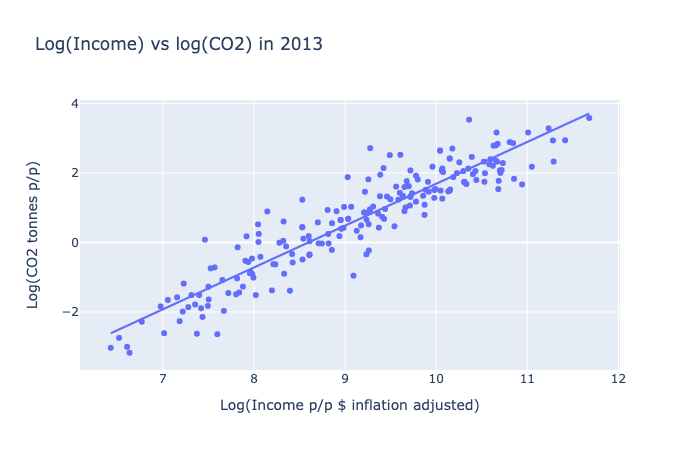

In [11]:
# Subset of df for priors over data that won't be used directly for the models
year = 2013
df_plt = df[df['year']==year]

# Visualisation
fig = px.scatter(df_plt, x='log_income',y='log_co2', trendline='ols',
           labels={
                     "log_income": "Log(Income p/p $ inflation adjusted)",
                     "log_co2": "Log(CO2 tonnes p/p)",
                     "continent": "Continent"
                 },
           title=f"Log(Income) vs log(CO2) in {year}")

# Show static image instead of interactive for github
fig.show("png")

It can be seen from the plot that the intercept parameter ($\alpha$) is negative and the scale parameter ($\beta$) is positive. We didn't select the exact values to not force the model too much but more to capture the trend.


### Pooled model

$\alpha \sim N(-3,1)$
Weakly informative prior for intercept based on plot in log scale.

$\beta \sim N(\frac{1}{3},1)$
Weakly informative prior for scale based on plot in log scale.

$\sigma \sim \Gamma(2,1)$
Weakly informative prior, considering that for standard deviations there are more values concentrated near 0 and a longer tail for positive values.

  
### Hierarchical model
  
$\alpha_0 \sim N(-3,1)$
Weakly informative prior for intercept based on plot in log scale.

$\beta_0 \sim N(\frac{1}{3},1)$
Weakly informative prior for scale based on plot in log scale.

$\sigma, \sigma_{alpha0},\sigma_{beta0}  \sim \Gamma(2,1)$
Weakly informative prior, considering that for standard deviations there are more values concentrated near 0 and a longer tail for positive values.

Generating input data for Stan:

In [12]:
# Subset of data for models
year = 2014
df_stan = df[df['year']==year]

# Generating input data
stan_data = dict(
    N = len(df_stan), # Number of data points
    K = len(df_stan['continent_number'].unique()), # Number of groups (continents)
    z = df_stan['continent_number'], # Group indicator
    x = df_stan['log_income'], # Observed income
    y = df_stan['log_co2'], # Observed co2
    xpred = df_stan['log_income'],
    pmualpha = -3, # Prior mean for alpha
    psalpha = 1, # Prior std for alpha
    pmubeta = 1/3, # Prior mean for beta
    psbeta = 1 # Prior std for beta
    )

## Stan code
Models are built directly in Stan and inference is run using pystan.

- Stan Modeling Language Users Guide and Reference Manual. https://mc-stan.org
- Pystan documentation. https://pystan.readthedocs.org

### Pooled model

In [13]:
with open('stan_code/pooled_co2.stan') as file:
    print(file.read())

// Pooled model: All groups with common variance
// and common alpha and beta for mean
data {
  int<lower=0> N; // number of data points
  int<lower=0> K; // number of data groups
  int<lower=1, upper=K> z[N]; // group indicator
  vector [N] x; // observation log(income)
  vector [N] y; // observation log(co2)
  vector [N] xpred; // prediction income
  real pmualpha; // prior mean for alpha
  real psalpha; // prior mean for alpha
  real pmubeta; // prior mean for alpha
  real psbeta; // prior mean for alpha
}
parameters {
  real alpha; // common alpha
  real beta; // common beta
  real<lower=0> sigma; // common std
}
transformed parameters {
  vector [N] mu;
  mu = alpha + beta * x;
}
model {
  alpha ~ normal(pmualpha, psalpha); // informative prior for alpha
  beta ~ normal(pmubeta, psbeta); // informative prior for beta 
  sigma ~ gamma(2, 1); // weakly informative prior 
  y ~ normal(mu, sigma);
}
generated quantities {
  vector [N] ypred;
  vector [N] log_lik;
  for (i in 1:N)
    

In [14]:
# Generating model instance and fitting
sm_pooled = pystan.StanModel(file='stan_code/pooled_co2.stan', model_name='pooled_co2')
fit_pooled = sm_pooled.sampling(data=stan_data)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL pooled_co2_b4e4e2a75f753be8979eb49cede32ce6 NOW.


### Hierarchical model

In [15]:
with open('stan_code/hierarchical_co2.stan') as file:
    print(file.read())

// Hierarchical model: Common variance and 
// hierarchical prior for alpha and beta
data {
  int<lower=0> N; // number of data points
  int<lower=0> K; // number of data groups
  int<lower=1, upper=K> z[N]; // group indicator
  vector [N] x; // observation log(income)
  vector [N] y; // observation log(co2)
  vector [N] xpred; // prediction income
  real pmualpha; // prior mean for alpha
  real psalpha; // prior mean for alpha
  real pmubeta; // prior mean for alpha
  real psbeta; // prior mean for alpha
}
parameters {
  real alpha0; // prior alpha
  real <lower=0> salpha0; // prior alpha std
  real beta0; // prior beta
  real <lower=0> sbeta0; // prior beta std
  vector[K] alpha; // group alpha
  vector[K] beta; // group alpha
  real<lower=0> sigma; // common std
}
transformed parameters {
  vector [N] mu;
  for (i in 1:N)
    mu[i] = alpha[z[i]] + beta[z[i]] * x[i]; // hierarchical model
}
model {
  alpha0 ~ normal(pmualpha, psalpha); // informative prior for population alpha
  salp

In [16]:
# Generating model instance and fitting
sm_hierarchical = pystan.StanModel(file='stan_code/hierarchical_co2.stan', model_name='hierarchical_co2')
fit_hierarchical = sm_hierarchical.sampling(data=stan_data)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL hierarchical_co2_70f04a4913a88ba97378e9e694068b0d NOW.


## Convergence diagnostics

Is key to review the convergence per variable, for it the key metrics are:
- $\hat{R}$: Compares the variance between and within chains. When there is convergence of chains $\hat{R}$ converges to 1, higher values indicate non-convergence.
- ESS: Effective sample size. Simile of number of number of independent draws but for MCMC. MCMC has autocorrelated samples. Higher values indicate a more stable estimate of uncertainty in parameters.

More information:
- Aki Vehtari, Andrew Gelman, Daniel Simpson, Bob Carpenter, and Paul-Christian Bürkner (2019).
Rank-normalization, folding, and localization: An improved Rb for assessing convergence of MCMC.
Bayesian analysis, doi:10.1214/20-BA1221. https://projecteuclid.org/euclid.ba/1593828229.
- https://mc-stan.org/docs/2_25/reference-manual/effective-sample-size-section.html

### Pooled model

In [17]:
fit_pooled


For the full summary use 'print(fit)'

Inference for Stan model: pooled_co2_b4e4e2a75f753be8979eb49cede32ce6.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   -9.43  9.4e-3   0.31 -10.02  -9.65  -9.44  -9.22  -8.78   1131    1.0
beta     1.11  1.0e-3   0.03   1.04   1.08   1.11   1.13   1.17   1125    1.0
sigma    0.58  7.7e-4   0.03   0.52   0.56   0.58    0.6   0.64   1614    1.0
mu[1]   -1.15  1.9e-3   0.07  -1.29   -1.2  -1.15   -1.1  -1.01   1453    1.0
mu[2]    0.82  6.5e-4   0.04   0.74   0.79   0.82   0.85    0.9   4051    1.0
mu[3]    1.08  7.1e-4   0.04    1.0   1.05   1.08   1.11   1.17   3639    1.0
mu[4]    2.41  1.7e-3   0.07   2.27   2.36   2.41   2.45   2.53   1573    1.0
mu[5]    0.32  7.5e-4   0.04   0.24   0.29   0.32   0.35   0.41   3320    1.0
mu[6]    1.56  9.8e-4   0.05   1.46   1.52   1.56   1.59   1.65   247

We are also going to access to the elements of the summary to make a more detailed analysis of the convergence

In [18]:
# Summary
fit_pooled_summary = fit_pooled.summary()

# Summary is a dict
fit_pooled_summary.keys()

odict_keys(['summary', 'c_summary', 'summary_rownames', 'summary_colnames', 'c_summary_rownames', 'c_summary_colnames'])

In [19]:
print(fit_pooled_summary['summary_colnames'])

('mean', 'se_mean', 'sd', '2.5%', '25%', '50%', '75%', '97.5%', 'n_eff', 'Rhat')


In [20]:
def fit_sum(fit_summary=fit_pooled_summary):
    """R hat & ESS summary"""
    # Accessing Rhat
    rhat_val = np.min(fit_summary['summary'][:,-1])
    print(f"min Rhat: {rhat_val:.5f}")
    rhat_val = np.max(fit_summary['summary'][:,-1])
    print(f"max Rhat: {rhat_val:.5f}")

    # Accessing Effective sample size
    ess_val = np.min(fit_summary['summary'][:,-2])
    print(f"min ESS: {ess_val:.3f}")
fit_sum()

min Rhat: 0.99915
max Rhat: 1.00434
min ESS: 1125.363


In [21]:
# Sampler parameters
fit_pooled_s_params = fit_pooled.get_sampler_params(inc_warmup = False)

# Information available per chain
len(fit_pooled_s_params)

4

In [22]:
# Each element of the list is an ordered dict
fit_pooled_s_params[0].keys()

odict_keys(['accept_stat__', 'stepsize__', 'treedepth__', 'n_leapfrog__', 'divergent__', 'energy__'])

In [23]:
def chain_sum(chain_summary=fit_pooled_s_params):
    """Max tree depth and divergent chains summary"""
    # Max tree depth by chain
    max_tree_depth = []
    for i in range(0, len(chain_summary)):
        max_tree_depth.append(np.max(chain_summary[i]['treedepth__']))
    print("max tree depth by chain:")
    print(max_tree_depth)

    # Divergent chains
    div_chains = []
    for i in range(0, len(chain_summary)):
        div_chains.append(np.max(chain_summary[i]['divergent__']))
    print("divergent chains:")
    print(div_chains)
chain_sum()

max tree depth by chain:
[6.0, 6.0, 6.0, 6.0]
divergent chains:
[0.0, 0.0, 0.0, 0.0]


- $\hat{R}$ values for all parameters were 1.00 (2 decimals rounding), so there's good convergence
- ESS values are over 1,000 so estimates are stable
- Tree depth values are below the maximum tree depth (10)
- There's convergence of chains for all the variables

### Hierarchical model

In [24]:
fit_hierarchical


For the full summary use 'print(fit)'

Inference for Stan model: hierarchical_co2_70f04a4913a88ba97378e9e694068b0d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha0    -4.56    0.02   1.07  -6.63   -5.3  -4.55  -3.82   -2.5   4290    1.0
salpha0     4.1    0.02    1.2   2.14   3.25   3.94   4.82   6.81   3744    1.0
beta0       1.0  3.5e-3   0.18   0.58   0.91   1.01    1.1   1.36   2599    1.0
sbeta0     0.38  4.3e-3    0.2   0.14   0.25   0.33   0.46   0.91   2093    1.0
alpha[1] -11.06  9.7e-3   0.57 -12.14 -11.45 -11.05 -10.66  -9.92   3499    1.0
alpha[2]  -9.11    0.01   0.61  -10.3  -9.53  -9.12   -8.7  -7.88   3003    1.0
alpha[3]   -5.2    0.02   1.26  -7.75  -6.05  -5.19  -4.36  -2.75   3156    1.0
alpha[4]  -9.79    0.02   1.18 -12.03 -10.59  -9.79  -8.99  -7.51   2943    1.0
alpha[5]  -8.49    0.02   1.08 -10.68  -9.22 

In [25]:
# Summary
fit_hierarchical_summary = fit_hierarchical.summary()

# Sampler parameters
fit_hierarchical_s_params = fit_hierarchical.get_sampler_params(inc_warmup = False)

# Statistics by custom functions
fit_sum(fit_hierarchical_summary)
chain_sum(fit_hierarchical_s_params)

min Rhat: 0.99904
max Rhat: 1.00235
min ESS: 1468.713
max tree depth by chain:
[7.0, 7.0, 7.0, 7.0]
divergent chains:
[0.0, 0.0, 0.0, 0.0]


- $\hat{R}$ values for all parameters were 1.00 (2 decimals rounding), so there's good convergence
- ESS values are over 1,000 so estimates are stable
- Tree depth values are below the maximum tree depth (10)
- There's convergence of chains for all the variables

## Posterior predictive checking

Exploratory analysis of the models, posterior analysis and model checks are performed using ArviZ.
- ArviZ documentation https://arviz-devs.github.io/arviz/index.html


We are going to compare the distribution estimate (Kernel Density Estimate) of the posterior predictive (estimated $log(CO_2)$) to the observed (real) values. 

### Pooled model

In [26]:
# Converting data to Arviz inference data
# Helps to use of all the functionalities
fit = fit_pooled
pooled_data = az.from_pystan(
    posterior = fit,
    posterior_predictive="ypred",
    observed_data=["y"],
    constant_data=["x"],
    log_likelihood="log_lik",
    coords={"country": np.arange(stan_data["N"]),
            "continent": np.arange(stan_data["K"])},
    dims={
        "y": ["country"],
        "x": ["country"],
        "log_lik": ["country"],
        "ypred": ["country"],
        "mu": ["country"]
    },
)

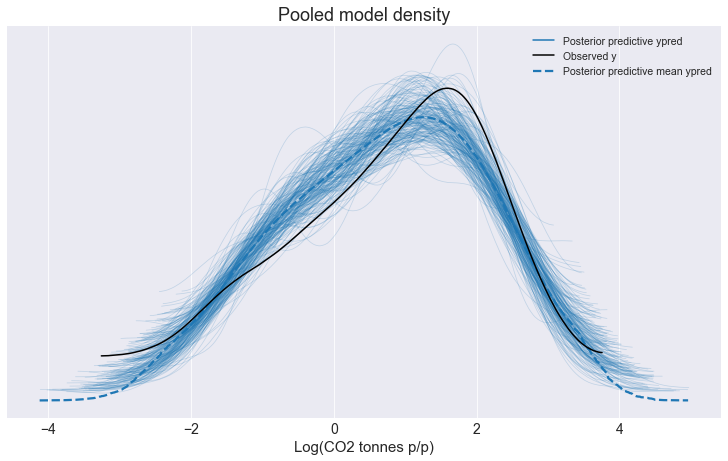

In [27]:
# Posterior predictive check
model_name = "Pooled"
az_data = pooled_data
az.plot_ppc(az_data, data_pairs = {"y" : "ypred"}, num_pp_samples=200)
plt.xlabel('Log(CO2 tonnes p/p)')
plt.title(f"{model_name} model density", fontdict={'fontsize': 18});

### Hierarchical model

In [28]:
# Converting data to Arviz inference data
# Helps to use of all the functionalities
fit = fit_hierarchical
hierarchical_data = az.from_pystan(
    posterior = fit,
    posterior_predictive="ypred",
    observed_data=["y"],
    constant_data=["x"],
    log_likelihood="log_lik",
    coords={"country": np.arange(stan_data["N"]),
            "continent": np.arange(stan_data["K"])},
    dims={
        "alpha": ["continent"],
        "beta": ["continent"],
        "y": ["country"],
        "x": ["country"],
        "log_lik": ["country"],
        "ypred": ["country"],
        "mu": ["country"]
    },
)

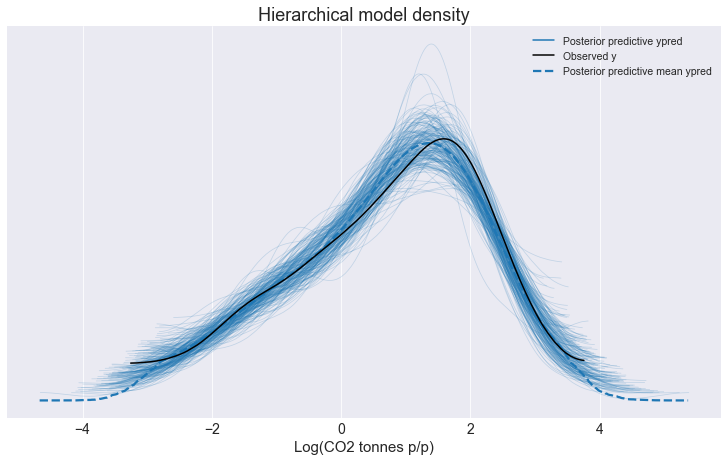

In [29]:
# Posterior predictive check
model_name = "Hierarchical"
az_data = hierarchical_data
az.plot_ppc(az_data, data_pairs = {"y" : "ypred"}, num_pp_samples=200)
plt.xlabel('Log(CO2 tonnes p/p)')
plt.title(f"{model_name} model density", fontdict={'fontsize': 18});

We can observe that we fit better the real distribution with the hierarchical model, especially for $log(CO_2) < 2$

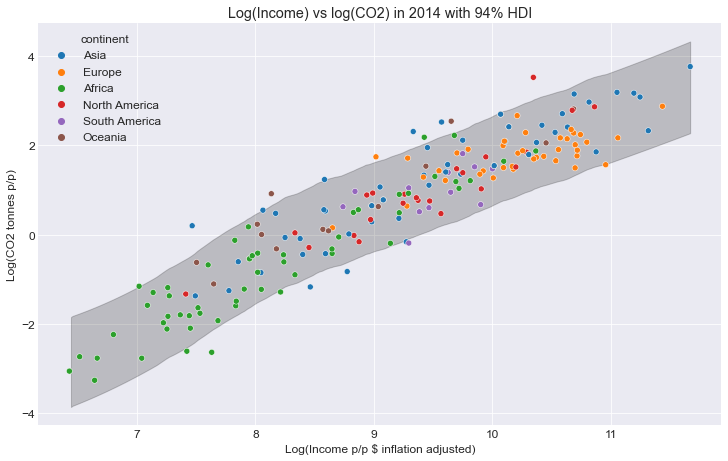

In [30]:
import seaborn as sns

# Highest density interval
# Subseting with [0] to remove variable dimension from xarray
ax = az.plot_hpd(
    x = az_data.constant_data.to_array()[0],
    y = az_data.posterior_predictive.to_array()[0],
    color="k", fill_kwargs={"alpha": .2},
)
ax.set(xlabel='Log(Income p/p $ inflation adjusted)',
       ylabel='Log(CO2 tonnes p/p)',
       title='Log(Income) vs log(CO2) in 2014 with 94% HDI')

# Visualise observed values
_= sns.scatterplot(data=df_stan, x="log_income", y="log_co2", hue='continent')

We can also visualise our posterior predictive distribution 94% probability interval compared to the actual data to see how good the prediction is. We can observe that our credible interval is appropiate for the observed data.

## Marginal posterior intervals

We are also going to observe our estimates for the distribution of the different parameters. In this case we will only analyse in detail the hierarchical distribution.

### Hierarchical model

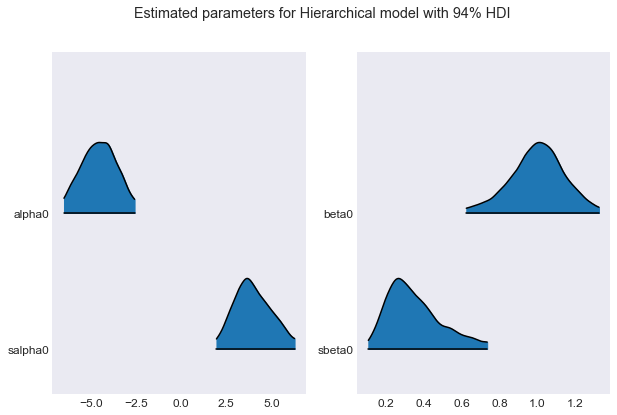

In [31]:
# Generating 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2)

# Plot parametersfor alpha0
az.plot_forest(az_data, kind='ridgeplot',
              var_names=['alpha0','salpha0'],
              combined=True,
              ridgeplot_overlap=0.7,
              ax=ax1)
fig.suptitle('Estimated parameters for Hierarchical model with 94% HDI')

# Plot parametersfor beta0
_= az.plot_forest(az_data, kind='ridgeplot',
              var_names=['beta0','sbeta0'],
              combined=True,
              ridgeplot_overlap=0.7,
              ax=ax2)

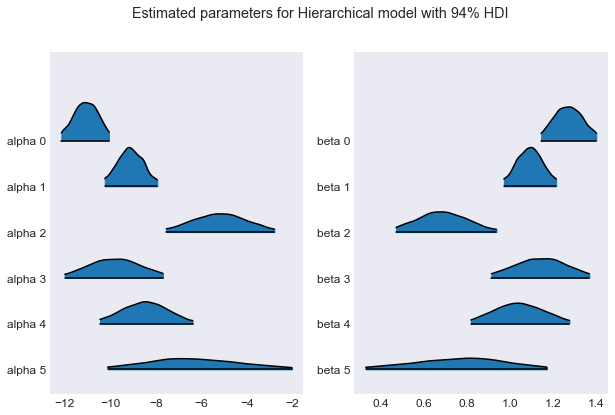

In [32]:
# Generating 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2)

# Plot alpha for different continents
az.plot_forest(az_data, kind='ridgeplot',
              var_names=['alpha'],
              combined=True,
              ridgeplot_overlap=0.7,
              ax=ax1)
fig.suptitle('Estimated parameters for Hierarchical model with 94% HDI')

# Plot beta for different continents
_= az.plot_forest(az_data, kind='ridgeplot',
              var_names=['beta'],
              combined=True,
              ridgeplot_overlap=0.7,
              ax=ax2)

In [33]:
df_stan[['continent','continent_number']].groupby(['continent']).mean().reset_index()['continent']

0           Africa
1             Asia
2           Europe
3    North America
4          Oceania
5    South America
Name: continent, dtype: object

We notice that there are clear differences between continents, which explains why the hierarchical model works better. There's a possibility of improving South America (5th continent), considering how wide the distribution is for the parameters $\alpha$ & $\beta$. A good idea would be to split the continent.

## Model comparison

We will use arviz.loo module for leave-one-out cross-validation comparison. 

This methodology calculates predictive posteriors removing one of the data points at a time. Important metrics:

- $elpd_{loo}$ : Expected log pointwise predictive density leaving one out cross validation. Estimate of sum of the density of the different data points removed (in log scale), adding also importance sampling. A lower (more negative) value, indicates a lower probability of obtaining the points from our posterior predictive distribution. Meaning a worst predictive power.
- $p_{loo}$: Effective number of parameters. Difference between log pointwise predictive density (without removing points, non cross validated) and $elpd_{loo}$. In well behaving cases is lower than the total numbers of parameters in the model and the amount of observed data.

More information:
- Vehtari, A., Gelman, A., and Gabry, J. (2017). Practical Bayesian model evaluation using leave-one-out cross-validation and WAIC. Statistics and Computing. 27(5), 1413–1432. doi:10.1007/s11222-016-9696-4. [online](https://link.springer.com/article/10.1007/s11222-016-9696-4), [arXiv preprint arXiv:1507.04544](https://arxiv.org/abs/1507.04544).
- https://avehtari.github.io/modelselection/

### Pooled model

In [34]:
# Pooled
az_data = pooled_data

# Leave one out cross validation
az.loo(az_data, pointwise=True)

Computed from 4000 by 200 log-likelihood matrix

         Estimate       SE
elpd_loo  -174.89    10.57
p_loo        3.18        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      200  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

### Hierarchical model

In [35]:
# Hierarchical
az_data = hierarchical_data

# Leave one out cross validation
az.loo(az_data, pointwise=True)

Computed from 4000 by 200 log-likelihood matrix

         Estimate       SE
elpd_loo  -157.79    10.79
p_loo       10.66        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      200  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

### Final Comparison

In [36]:
# Leave one out cross validation comparison between models
az.compare({"hierarchical": hierarchical_data,
           "pooled": pooled_data})

/Users/Yal/miniconda3/envs/stan/lib/python3.7/site-packages/arviz/stats/stats.py:150: UserWarning:


The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.



,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
hierarchical,0,-157.79,10.6635,0,0.99566,10.8069,0,False,log
pooled,1,-174.886,3.18103,17.0954,0.00433981,10.7175,6.18915,False,log


The hierarchical model is better than the pooled model, specially considering that all k estimates are reliable and the hierarchical model has a higher elpd_loo value.

## Predictive performance assesment

### Hierarchical model

We will measure the RSME (Roor Mean Squared Error) of the predictions per sample.

In [37]:
# rmse function
def rmse_bayes(y, yhat_t):
    """Calculates bayesian rmse per sample
    Expects to receive y: observations as an array of n elements
    Expects to receive yhat transposed: predictions as an array of shape (samples, n)
    """
    # Amount of samples
    samples = yhat_t.shape[0]
    
    # Transform observations to be of shape (samples, n)
    # All observations are available per sample
    observed = np.tile(y, (samples,1))
    
    # Subsctracting only predictions made for the same sample
    diff = yhat_t-observed
    
    # RMSE calculation per sample
    return np.sqrt(np.mean(np.square(diff), axis=1))

In [38]:
# Data transformed to required format
y_true = az_data.observed_data["y"].values
y_pred = az_data.posterior_predictive.stack(sample=("chain", "draw"))["ypred"].values.T

# RMSE distribution
rmse_dist = rmse_bayes(y_true, y_pred)

# Quantiles
quantiles = [0.025, 0.5, 0.975]
quantiles_val = np.quantile(rmse_dist, quantiles)

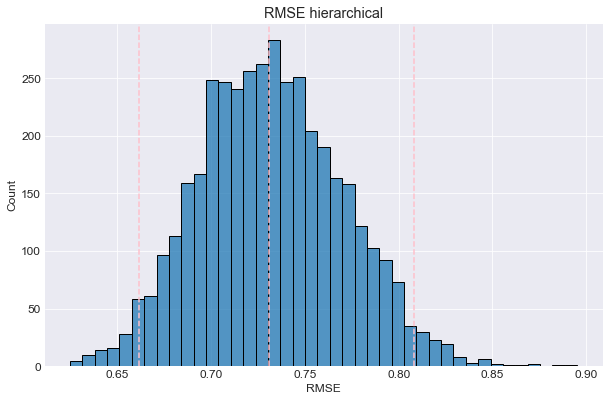

In [39]:
# RMSE histogram
fig, ax = plt.subplots(1, 1)
sns.histplot(rmse_dist)
ax.set(xlabel='RMSE',
       title='RMSE hierarchical')
# Adding qunatiles vertical lines
for i in np.arange(len(quantiles)):
    plt.axvline(quantiles_val[i], color='pink', linestyle='--')

In [40]:
# Values per quantile
for i in np.arange(len(quantiles)):
    print(f"{quantiles[i]:.1%}: {quantiles_val[i]:.2f}")

2.5%: 0.66
50.0%: 0.73
97.5%: 0.81


In [41]:
# Arrays rounded function
def array_rounded(array, dec = 2):
    rounded = []
    for i in np.arange(len(array)):
        rounded.append(np.round(array[i],2))
    return rounded

In [42]:
# RMSE 95% interval
rmse_interval = array_rounded([quantiles_val[0],quantiles_val[2]])
print(f"95% interval for RMSE: {rmse_interval}")

95% interval for RMSE: [0.66, 0.81]


In [43]:
# Interval of possible values for log(CO2)
co2_interval = array_rounded([df_stan['log_co2'].min(),df_stan['log_co2'].max()])
print(f"log(CO2) interval: {co2_interval}")

log(CO2) interval: [-3.26, 3.76]


Comparing the error to the scale of values from $log(CO_2)$, we can see that we get a reasonable error

We are also going to calculare the Bayesian $R^2$

In [44]:
# R2 score
az.r2_score(y_true, y_pred)

r2        0.870302
r2_std    0.005425
dtype: float64

We can observe that our predictions have a good fit

# Sensitivity analysis with respect to prior choices

In the previous hierarchical model we used weekly informative priors. $\alpha_0 \sim N(-3,1)$ & $\beta_0 \sim N(\frac{1}{3},1)$.

In this section we will plot posterior predictive checks with vage prior and specific informative prior to compare the results.

- Vague prior: $\alpha_0 \sim N(0,1\mathrm{e}{6})$ & $\beta_0 \sim N(0,1\mathrm{e}{6})$ 
- Specific informative prior: $\alpha_0 \sim N(-10.05,0.1)$ & $\beta_0 \sim N(1.17,0.1)$

## Vague prior

Generating input data for Stan with vague prior:

In [45]:
# Generating input data
stan_data_1 = dict(
    N = len(df_stan), # Number of data points
    K = len(df_stan['continent_number'].unique()), # Number of groups (continents)
    z = df_stan['continent_number'], # Group indicator
    x = df_stan['log_income'], # Observed income
    y = df_stan['log_co2'], # Observed co2
    xpred = df_stan['log_income'],
    pmualpha = 0, # Prior mean for alpha
    psalpha = 1000000, # Prior std for alpha
    pmubeta = 0, # Prior mean for beta
    psbeta = 1000000 # Prior std for beta
    )

# Fitting based on existing model instance
fit_hierarchical_1 = sm_hierarchical.sampling(data=stan_data_1)

In [46]:
fit_hierarchical_1


For the full summary use 'print(fit)'

Inference for Stan model: hierarchical_co2_70f04a4913a88ba97378e9e694068b0d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha0    -9.39    0.03   0.83 -10.79  -9.89   -9.5  -8.97  -7.45   1022    1.0
salpha0    1.28    0.07   0.89   0.04   0.57   1.14    1.8   3.28    183   1.02
beta0      1.11  4.4e-3   0.13   0.86   1.06   1.12   1.17   1.29    911    1.0
sbeta0     0.18    0.01   0.18   0.01   0.06   0.14   0.24   0.62    284   1.01
alpha[1] -10.62    0.04   0.66 -11.97 -11.08 -10.61 -10.13  -9.52    244   1.02
alpha[2]  -9.42    0.02   0.55 -10.44  -9.79  -9.46  -9.05  -8.28   1162   1.01
alpha[3]  -8.01    0.11   1.56 -10.28  -9.35  -8.21   -6.9  -4.77    195   1.02
alpha[4]  -9.88    0.02   0.83 -11.74 -10.33  -9.83  -9.38   -8.3   1547    1.0
alpha[5]  -9.27    0.02   0.79  -10.8  -9.78 

In [47]:
# Summary
fit_hierarchical_summary_1 = fit_hierarchical_1.summary()

# Sampler parameters
fit_hierarchical_s_params_1 = fit_hierarchical_1.get_sampler_params(inc_warmup = False)

# Statistics by custom functions
fit_sum(fit_hierarchical_summary_1)
chain_sum(fit_hierarchical_s_params_1)

min Rhat: 0.99921
max Rhat: 1.05387
min ESS: 77.941
max tree depth by chain:
[8.0, 8.0, 8.0, 8.0]
divergent chains:
[1.0, 1.0, 1.0, 1.0]


- Some $\hat{R}$ values are 1.01
- ESS values under 1,000 for several variables, so estimates are NOT stable
- There is divergence in all the chains

### Posterior predictive check with vague prior

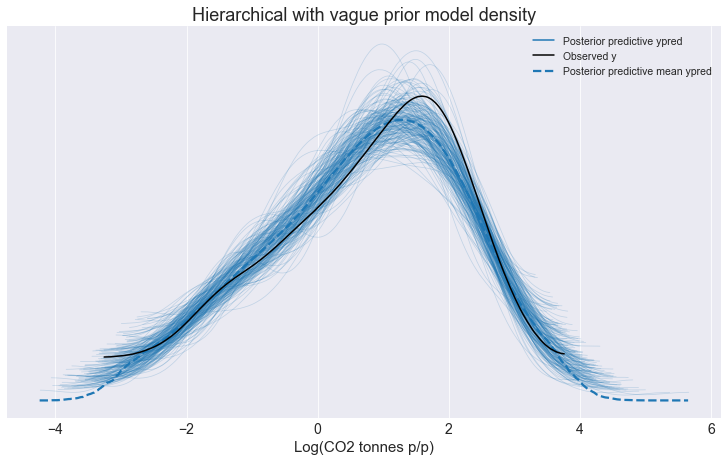

In [48]:
# Converting data to Arviz inference data
# Helps to use of all the functionalities
fit = fit_hierarchical_1
hierarchical_data_1 = az.from_pystan(
    posterior = fit,
    posterior_predictive="ypred",
    observed_data=["y"],
    constant_data=["x"],
    log_likelihood="log_lik",
    coords={"country": np.arange(stan_data["N"]),
            "continent": np.arange(stan_data["K"])},
    dims={
        "alpha": ["continent"],
        "beta": ["continent"],
        "y": ["country"],
        "x": ["country"],
        "log_lik": ["country"],
        "ypred": ["country"],
        "mu": ["country"]
    },
)

# Posterior predictive check
model_name = "Hierarchical with vague prior"
az_data = hierarchical_data_1
az.plot_ppc(az_data, data_pairs = {"y" : "ypred"}, num_pp_samples=200)
plt.xlabel('Log(CO2 tonnes p/p)')
plt.title(f"{model_name} model density", fontdict={'fontsize': 18});

Posterior predictive is worst than Hierarchical, but is still reasonable and close to previous values

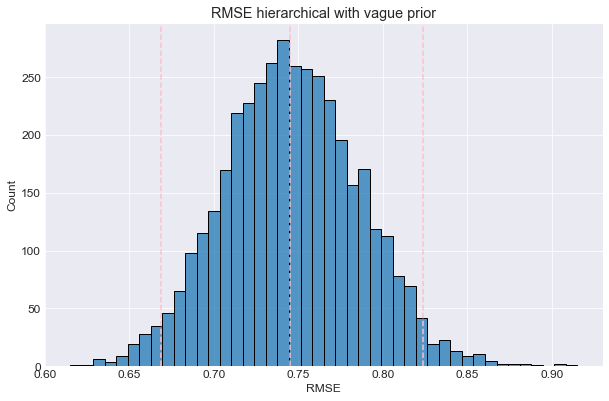

In [49]:
y_true = az_data.observed_data["y"].values
y_pred = az_data.posterior_predictive.stack(sample=("chain", "draw"))["ypred"].values.T

# RMSE distribution
rmse_dist = rmse_bayes(y_true, y_pred)

# Quantiles
quantiles = [0.025, 0.5, 0.975]
quantiles_val = np.quantile(rmse_dist, quantiles)

# RMSE histogram
fig, ax = plt.subplots(1, 1)
sns.histplot(rmse_dist)
ax.set(xlabel='RMSE',
       title='RMSE hierarchical with vague prior')
# Adding qunatiles vertical lines
for i in np.arange(len(quantiles)):
    plt.axvline(quantiles_val[i], color='pink', linestyle='--')

In [50]:
# R2 score
az.r2_score(y_true, y_pred)

r2        0.868288
r2_std    0.004189
dtype: float64

Errors are close to previous values

## Specific informative prior

Generating input data for Stan with specific informative prior

In [51]:
# Generating input data
stan_data_2 = dict(
    N = len(df_stan), # Number of data points
    K = len(df_stan['continent_number'].unique()), # Number of groups (continents)
    z = df_stan['continent_number'], # Group indicator
    x = df_stan['log_income'], # Observed income
    y = df_stan['log_co2'], # Observed co2
    xpred = df_stan['log_income'],
    pmualpha = -10.05, # Prior mean for alpha
    psalpha = 0.1, # Prior std for alpha
    pmubeta = 1.17, # Prior mean for beta
    psbeta = 0.1 # Prior std for beta
    )

# Fitting based on existing model instance
fit_hierarchical_2 = sm_hierarchical.sampling(data=stan_data_2)

In [52]:
fit_hierarchical_2


For the full summary use 'print(fit)'

Inference for Stan model: hierarchical_co2_70f04a4913a88ba97378e9e694068b0d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha0   -10.03  2.1e-3   0.09 -10.22  -10.1 -10.03  -9.97  -9.85   1961    1.0
salpha0    0.43    0.01    0.3   0.08   0.23   0.35   0.56   1.21    708    1.0
beta0      1.17  7.9e-4   0.03    1.1   1.15   1.17   1.19   1.23   1739    1.0
sbeta0     0.05  2.1e-3   0.05 6.7e-3   0.02   0.04   0.06   0.18    513   1.01
alpha[1] -10.31  9.4e-3    0.3 -11.03 -10.47 -10.26 -10.12  -9.85    991   1.01
alpha[2]  -9.84  7.5e-3   0.29 -10.35 -10.02  -9.87  -9.69  -9.18   1453    1.0
alpha[3]  -9.86    0.01    0.4 -10.43 -10.11  -9.93  -9.69  -8.78    872    1.0
alpha[4] -10.06  6.1e-3    0.3 -10.71 -10.21 -10.05  -9.88  -9.47   2424    1.0
alpha[5]  -9.78  7.7e-3   0.32 -10.36  -9.98 

In [53]:
# Summary
fit_hierarchical_summary_2 = fit_hierarchical_2.summary()

# Sampler parameters
fit_hierarchical_s_params_2 = fit_hierarchical_2.get_sampler_params(inc_warmup = False)

# Statistics by custom functions
fit_sum(fit_hierarchical_summary_2)
chain_sum(fit_hierarchical_s_params_2)

min Rhat: 0.99906
max Rhat: 1.00901
min ESS: 336.222
max tree depth by chain:
[7.0, 7.0, 6.0, 6.0]
divergent chains:
[1.0, 1.0, 1.0, 1.0]


- Some $\hat{R}$ values are 1.01, rounding to 2 decimals
- ESS values under 1,000 for few variables
- There is divergence in all the chains

### Posterior predictive check with specific informative prior

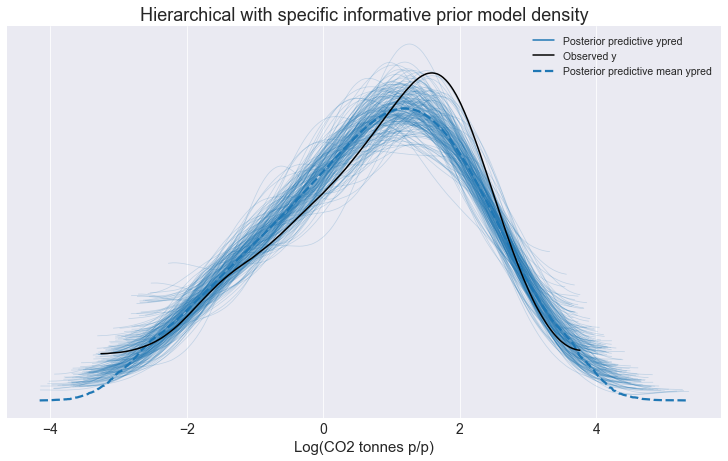

In [54]:
# Converting data to Arviz inference data
# Helps to use of all the functionalities
fit = fit_hierarchical_2
hierarchical_data_2 = az.from_pystan(
    posterior = fit,
    posterior_predictive="ypred",
    observed_data=["y"],
    constant_data=["x"],
    log_likelihood="log_lik",
    coords={"country": np.arange(stan_data["N"]),
            "continent": np.arange(stan_data["K"])},
    dims={
        "alpha": ["continent"],
        "beta": ["continent"],
        "y": ["country"],
        "x": ["country"],
        "log_lik": ["country"],
        "ypred": ["country"],
        "mu": ["country"]
    },
)

# Posterior predictive check
model_name = "Hierarchical with specific informative prior"
az_data = hierarchical_data_2
az.plot_ppc(az_data, data_pairs = {"y" : "ypred"}, num_pp_samples=200)
plt.xlabel('Log(CO2 tonnes p/p)')
plt.title(f"{model_name} model density", fontdict={'fontsize': 18});

Posterior predictive is worst than Hierarchical, but is still reasonable and close to previous values. Also a bit worst than with vague prior.

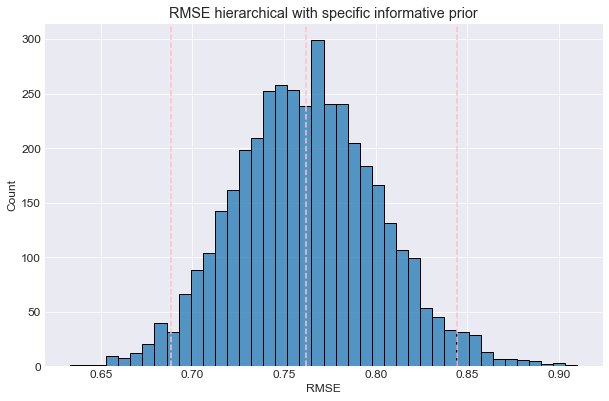

In [55]:
y_true = az_data.observed_data["y"].values
y_pred = az_data.posterior_predictive.stack(sample=("chain", "draw"))["ypred"].values.T

# RMSE distribution
rmse_dist = rmse_bayes(y_true, y_pred)

# Quantiles
quantiles = [0.025, 0.5, 0.975]
quantiles_val = np.quantile(rmse_dist, quantiles)

# RMSE histogram
fig, ax = plt.subplots(1, 1)
sns.histplot(rmse_dist)
ax.set(xlabel='RMSE',
       title='RMSE hierarchical with specific informative prior')
# Adding qunatiles vertical lines
for i in np.arange(len(quantiles)):
    plt.axvline(quantiles_val[i], color='pink', linestyle='--')

In [56]:
# R2 score
az.r2_score(y_true, y_pred)

r2        0.867956
r2_std    0.003136
dtype: float64

Errors are close to previous values.

In summary we can conclude that differences between models and errors are very small. The hierarchical model is robust and not very sensitive to prior selection.

# Forecasting


We will use the hierarchical model to forecast ${CO}_2$ emmisions per capita per country.

We won't use the 2018 estimations provided by Gapminder/CDIAC to update the posterior of the parameters. We want to evaluate how good our predictions are based on the information from 2014 for ${CO}_2$ and the updated 2018 information for income per capita.

In [57]:
# Subset of data for models
df_stan = df[df['year']==2014]

# Subset of data for predictions
df_stan_pred = df[df['year']==2018]

# Generating input data. Both dfs have same length and order
stan_data_pred = dict(
    N = len(df_stan), # Number of data points
    K = len(df_stan['continent_number'].unique()), # Number of groups (continents)
    z = df_stan['continent_number'], # Group indicator
    x = df_stan['log_income'], # Observed income 2014
    y = df_stan['log_co2'], # Observed co2 2014
    xpred = df_stan_pred['log_income'], # Observed income 2018
    pmualpha = -3, # Prior mean for alpha
    psalpha = 1, # Prior std for alpha
    pmubeta = 1/3, # Prior mean for beta
    psbeta = 1 # Prior std for beta
    )

# Fitting based on existing model instance
fit_hierarchical_pred = sm_hierarchical.sampling(data=stan_data_pred)

In [58]:
fit_hierarchical_pred


For the full summary use 'print(fit)'

Inference for Stan model: hierarchical_co2_70f04a4913a88ba97378e9e694068b0d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha0    -4.57    0.02   1.02   -6.6  -5.25  -4.56  -3.88  -2.58   3963    1.0
salpha0    4.11    0.02   1.24   2.17   3.23   3.95    4.8   7.05   4032    1.0
beta0      1.01  3.9e-3   0.19   0.63   0.91   1.01   1.11    1.4   2334    1.0
sbeta0     0.39  5.3e-3   0.23   0.14   0.25   0.34   0.47   0.96   1830    1.0
alpha[1] -11.07    0.01   0.57 -12.17 -11.45 -11.07  -10.7  -9.94   3072    1.0
alpha[2]  -9.14    0.01   0.62 -10.33  -9.56  -9.14  -8.73  -7.97   3338    1.0
alpha[3]  -5.25    0.02   1.26  -7.72   -6.1  -5.25  -4.38  -2.83   3199    1.0
alpha[4]  -9.79    0.02   1.19 -12.22 -10.56  -9.78   -9.0  -7.47   2650    1.0
alpha[5]  -8.48    0.02    1.1  -10.7  -9.22 

In [59]:
# Summary
fit_hierarchical_summary_pred = fit_hierarchical_pred.summary()

# Sampler parameters
fit_hierarchical_s_params_pred = fit_hierarchical_pred.get_sampler_params(inc_warmup = False)

# Statistics by custom functions
fit_sum(fit_hierarchical_summary_pred)
chain_sum(fit_hierarchical_s_params_pred)

min Rhat: 0.99913
max Rhat: 1.00271
min ESS: 1488.010
max tree depth by chain:
[7.0, 8.0, 7.0, 7.0]
divergent chains:
[0.0, 0.0, 0.0, 0.0]


- $\hat{R}$ values for all parameters were 1.00 (2 decimals rounding), so there's good convergence
- ESS values are over 1,000 so estimates are stable
- Tree depth values are below the maximum tree depth (10)
- There's convergence of chains for all the variables

In [60]:
# Converting data to Arviz inference data
# Helps to use of all the functionalities
# Useful variables are going to be ypred and xpred 
fit = fit_hierarchical_pred
hierarchical_data_pred = az.from_pystan(
    posterior = fit,
    posterior_predictive="ypred",
    #observed_data=["y"],
    constant_data=["x","xpred"],
    log_likelihood="log_lik",
    coords={"country": np.arange(stan_data["N"]),
            "continent": np.arange(stan_data["K"])},
    dims={
        "alpha": ["continent"],
        "beta": ["continent"],
        "y": ["country"],
        "x": ["country"],
        "xpred": ["country"],
        "log_lik": ["country"],
        "ypred": ["country"],
        "mu": ["country"]
    },
)

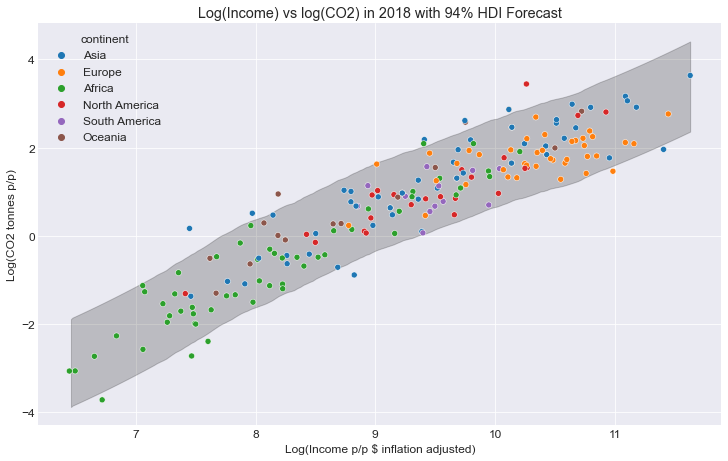

In [61]:
# Highest density interval
# Subseting with [1] in constants to obtain xpred
az_data = hierarchical_data_pred
ax = az.plot_hpd(
    x = az_data.constant_data.to_array()[1],
    y = az_data.posterior_predictive.to_array()[0],
    color="k", fill_kwargs={"alpha": .2},
)
ax.set(xlabel='Log(Income p/p $ inflation adjusted)',
       ylabel='Log(CO2 tonnes p/p)',
       title='Log(Income) vs log(CO2) in 2018 with 94% HDI Forecast')

# Visualise observed values 2018
_= sns.scatterplot(data=df_stan_pred, x="log_income", y="log_co2", hue='continent')

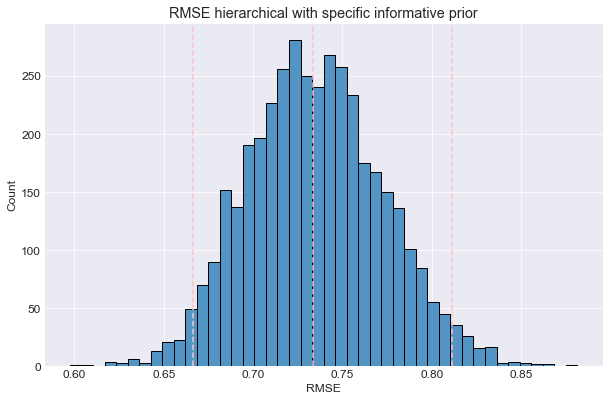

In [62]:
# 2018 real information
y_true = df_stan_pred['log_co2'].to_numpy()
y_pred = az_data.posterior_predictive.stack(sample=("chain", "draw"))["ypred"].values.T

# RMSE distribution
rmse_dist = rmse_bayes(y_true, y_pred)

# Quantiles
quantiles = [0.025, 0.5, 0.975]
quantiles_val = np.quantile(rmse_dist, quantiles)

# RMSE histogram
fig, ax = plt.subplots(1, 1)
sns.histplot(rmse_dist)
ax.set(xlabel='RMSE',
       title='RMSE hierarchical with specific informative prior')
# Adding qunatiles vertical lines
for i in np.arange(len(quantiles)):
    plt.axvline(quantiles_val[i], color='pink', linestyle='--')

In [63]:
# R2 score
az.r2_score(y_true, y_pred)

r2        0.870094
r2_std    0.005271
dtype: float64

Predictions for 2018 are quite close to real values, especially considering that we are only using 2014 to generate the posterior distribution. RMSE is similar to RMSE obtained for 2014.

# Conclusions

- The hierarchical model seems to be a reasonable approximation for the problem. The $CO_2$ emmisions can be estimated fairly well based on the income level of each country. 

- Model is robust and not very sensitive to prior selection.

- Data from 2014 and income from 2018 are useful to estimate the 2018 $CO_2$ emmisions per capita.

# Improvements suggestions

1. One of the quickest wins, would be to improve the wide distribution of the parameters for South America. A possible solution is to split South America in different groups, or to redistribute the countries in other existing continents.

2. The income and $CO_2$ emmisions relation can evolve over time, if we consider wider time frames. It would be important to include year as a factor in the model. This is mainly considering possible changes in awarness regarding climate change. Year considered as a factor could improve the predictions for emissions in upcoming years.

3. Include additional factors influencing the $CO_2$ contribution. For example in 2014 the emmisions of Germany almost doubled France emmisions, 8.8t vs 4.7t. On the other hand their incomes are relatively close \\$43K vs \\$38K. One possible explanation are the main sources of energy, coal vs nuclear power.